## Downloading the Dataset


#### Reference: [Paper](https://aclanthology.org/2022.acl-long.534.pdf)

In [ ]:
%%capture
!git clone https://github.com/uakarsh/sample_rvl_cdip_dataset.git
!pip install pytesseract
!sudo apt install tesseract-ocr
!pip install transformers
!pip install 'Pillow==7.1.2'

## Focus on Slide 2 of the paper mentioned as reference

* They have mentioned the following features, used for pre-training/fine-tuning. 
    1. Text Embedding (Mentioned in section 2.1.1): Tokenize the word (we would need a tokenizer, and then add the special tokens, that includes [SEP], [CLS] and [PAD].
    2. Layout Embedding (Mentioned in section 2.1.2): Generate a 2D sequence, where each portion contains the format as [xmin, xmax, ymin, ymax, width, height] (similar to LaTr).Note that, they are normalized in the range [0, 1000]
* Note that, we would be using tesseract for the purpose of OCR (it is free so.... :)  )




## Generating the OCR Results from the Image

In [ ]:
# %%writefile dataset.py
import pandas as pd
import os
from PIL import Image, ImageDraw
import numpy as np
import pytesseract
import torch

## I guess, I got my own script for it, from https://github.com/shabie/docformer/blob/master/src/docformer/dataset.py

def rescale_bbox(bbox, img_width : int, 
                 img_height : int, size : int = 1000):
  x0, x1, y0, y1, width, height = bbox
  x0 = int(size * (x0 / img_width))
  x1 = int(size * (x1 / img_width))
  y0 = int(size * (y0 / img_height))
  y1 = int(size * (y1 / img_height))
  width = int(size * (width / img_width))
  height = int(size * (height / img_height))
  return [x0, x1, y0, y1, width, height]

def coordinate_features(df_row):
    xmin, ymin, width, height = df_row["left"], df_row["top"], df_row["width"], df_row["height"]
    return [xmin, xmin + width, ymin, ymin + height, width, height]  ## [xmin, xmax, ymin, ymax, width, height]

def get_ocr_results(image_path : str):

    """
    Returns words and its bounding boxes from the image file path
    image_path: string containing the path of the image
    """

    ## Getting the Image
    image = Image.open(image_path)
    width, height = image.size

    ## OCR Processing
    ocr_df = pytesseract.image_to_data(image, output_type="data.frame")
    ocr_df = ocr_df.dropna().reset_index(drop=True)
    float_cols = ocr_df.select_dtypes("float").columns
    ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
    ocr_df = ocr_df.replace(r"^\s*$", np.nan, regex=True)
    ocr_df = ocr_df.dropna().reset_index(drop=True)
    ocr_df = ocr_df.sort_values(by=['left', 'top'])

    ## Finally getting the words and the bounding box
    words = list(ocr_df.text.apply(lambda x: str(x).strip()))
    actual_bboxes = ocr_df.apply(coordinate_features, axis=1).values.tolist()

    # add as extra columns
    assert len(words) == len(actual_bboxes)
    return {"words": words, "bbox": actual_bboxes}

## Stealed from here: https://github.com/uakarsh/latr/blob/main/src/latr/dataset.py

def get_tokens_with_boxes(unnormalized_word_boxes, list_of_words, 
                          tokenizer, pad_token_id : int = 0, 
                          pad_token_box = [0, 0, 0, 0, 0, 0], 
                          max_seq_len = 512, 
                          sep_token_box = [0, 0, 1000, 1000, 0, 0]
                          ):
    
    '''
    This function returns two items:
    1. unnormalized_token_boxes -> a list of len = max_seq_len, containing the boxes corresponding to the tokenized words, 
                                    one box might repeat as per the tokenization procedure
    2. tokenized_words -> tokenized words corresponding to the tokenizer and the list_of_words
    '''

    assert len(unnormalized_word_boxes) == len(list_of_words), "Bounding box length != total words length"
    
    length_of_box = len(unnormalized_word_boxes)
    unnormalized_token_boxes = []
    tokenized_words = []

    ## CLS, SEP tokens have to be appended
    unnormalized_token_boxes.extend([pad_token_box])
    tokenized_words.extend([tokenizer.cls_token_id])  ## CLS Token Box is same as pad_token_box, if not, you can change here

    ## Normal for loop
    idx = 0
    for box, word in zip(unnormalized_word_boxes, list_of_words):
      if idx != 0:
        new_word = " " + word
      else:
        new_word = word
      current_tokens = tokenizer(new_word, add_special_tokens = False).input_ids
      unnormalized_token_boxes.extend([box]*len(current_tokens))
      tokenized_words.extend(current_tokens)
      idx += 1

    ## For post processing the token box
    if len(unnormalized_token_boxes)<max_seq_len:
      unnormalized_token_boxes.extend([sep_token_box])
      unnormalized_token_boxes.extend([pad_token_box] * (max_seq_len-len(unnormalized_token_boxes)))
    
    else:
      unnormalized_token_boxes[max_seq_len - 1] = sep_token_box

    ## For post processing the tokenized words
    if len(tokenized_words) < max_seq_len:
      tokenized_words.extend([tokenizer.sep_token_id])
      tokenized_words.extend([pad_token_id]* (max_seq_len-len(tokenized_words)))

    else:
      tokenized_words[max_seq_len - 1] = tokenizer.sep_token_id
        
    return unnormalized_token_boxes[:max_seq_len], tokenized_words[:max_seq_len]


def create_features(
    img_path : str,
    tokenizer,
    max_seq_length : int = 512,
    size : int = 1000,
    use_ocr : bool = True,
    bounding_box = None,
    words = None ):
  
  image = Image.open(img_path).convert("RGB")
  ocr_results = get_ocr_results(img_path)
  ocr_results['rescale_bbox'] = list(map(lambda x: rescale_bbox(x, *image.size, size  = size), ocr_results['bbox']))
  boxes, words = get_tokens_with_boxes(ocr_results['rescale_bbox'], ocr_results['words'], tokenizer)
  torch_boxes = torch.as_tensor(boxes)
  torch_words = torch.as_tensor(words)

  return torch_boxes, torch_words, ocr_results['bbox']

## Extracting both the features simultaneously

From Slide: 4, the author says: In this paper, we initialize the text flow from
the existing pre-trained English **RoBERTaBASE** (Liu et al., 2019b) for our document pre-training, and combine LiLTBASE with the pre-trained **InfoXLMBASE** (Chi et al., 2021)/a new pre-trained RoBERTaBASE for multilingual/monolingual finetuning

## Testing the Code

In [ ]:
import pandas as pd
import os
from PIL import Image, ImageDraw
from transformers import RobertaTokenizerFast
# from dataset import create_features

In [ ]:
base_path = './sample_rvl_cdip_dataset/RVL-CDIP Invoice Class Dataset'
df = pd.DataFrame({'image_id':[os.path.join(base_path,i) for i in os.listdir(base_path)]})

In [ ]:
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
sample_tif_path = df.sample(5)['image_id'].values[3]

In [ ]:
enc = get_ocr_results(sample_tif_path)

In [ ]:
boxes, words, normal_box = create_features(img_path = sample_tif_path,
                               tokenizer = tokenizer,
                               )

In [ ]:
image = Image.open(sample_tif_path).convert("RGB")

In [ ]:
draw = ImageDraw.Draw(image)  

for curr_box in normal_box:
  curr_box = tuple(curr_box)
  x0, x1, y0, y1, width, height = curr_box
  draw.rectangle(xy = [(x0, y0), (x1, y1)], outline = 'purple')

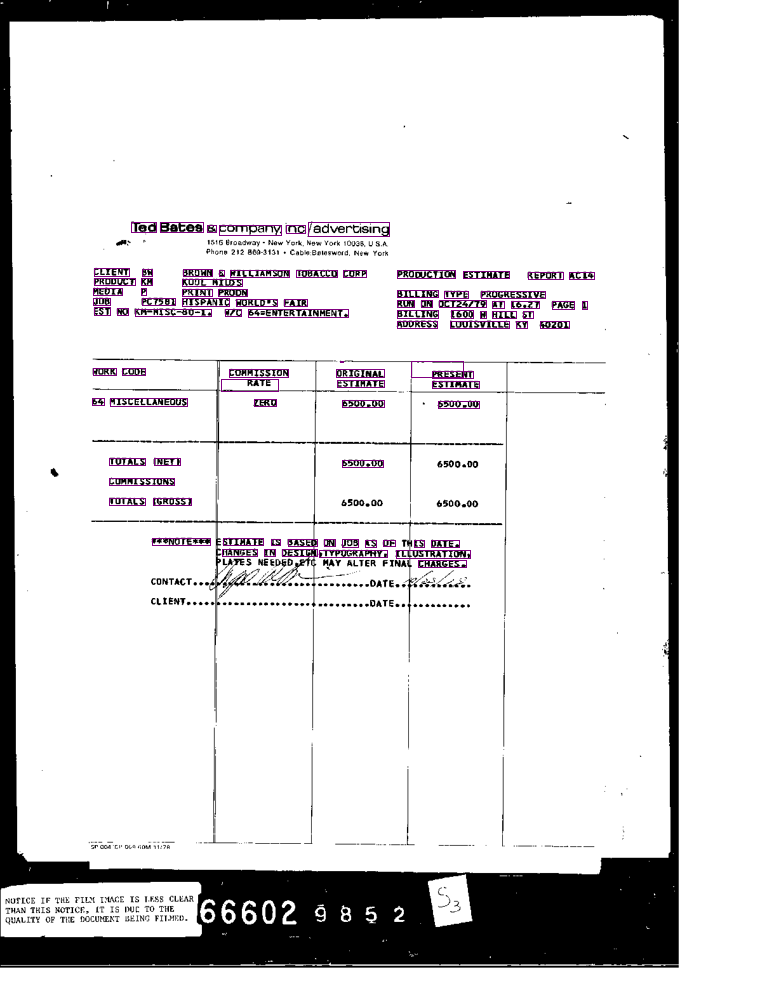

In [ ]:
image